In [1]:
import numpy as np
import pandas as pd
import re
import time
from optimization import SGDClassifier, GDClassifier
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('./toxic_train.csv')
test = pd.read_csv('./toxic_test.csv')

In [3]:
train.head(5)

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False


In [4]:
test.head(5)

,Unnamed: 0,comment_text,is_toxic
0,0,Thank you for understanding. I think very high...,False
1,1,:Dear god this site is horrible.,False
2,2,"""::: Somebody will invariably try to add Relig...",False
3,3,""" \n\n It says it right there that it IS a typ...",False
4,4,""" \n\n == Before adding a new product to the l...",False


### Preprocessing

In [5]:
def transfrom_target(df):
    target = df.pop('is_toxic')
    target[target == False] = -1
    target[target == True] = 1
    return target.astype(int)

def remove_extra_symbols(df):
    df['comment_text'] = df.apply(lambda x: re.sub('\n', ' ', x.comment_text), axis=1)
    df['comment_text'] = df.apply(lambda x: re.sub('[^0-9a-zA-Z]+', ' ', x.comment_text), axis=1)
    df['comment_text'] = df.apply(lambda x: re.sub('\s+', ' ', x.comment_text), axis=1)
    df['comment_text'] = df['comment_text'].str.lower().str.strip()

In [6]:
y_train = transfrom_target(train)
y_test = transfrom_target(test)

remove_extra_symbols(train)
remove_extra_symbols(test)

In [7]:
test.head(5)

,Unnamed: 0,comment_text
0,0,thank you for understanding i think very highl...
1,1,dear god this site is horrible
2,2,somebody will invariably try to add religion r...
3,3,it says it right there that it is a type the t...
4,4,before adding a new product to the list make s...


In [8]:
count_vectorizer_params = {
    'min_df': 0.0001
}

In [9]:
count_vec = CountVectorizer(**count_vectorizer_params)
X_train = count_vec.fit_transform(train['comment_text'])
X_test = count_vec.transform(test['comment_text'])

In [10]:
# appending identity vectors 
id_vec_train = scipy.sparse.csr_matrix(np.ones(X_train.shape[0])[:, np.newaxis])
id_vec_test = scipy.sparse.csr_matrix(np.ones(X_test.shape[0])[:, np.newaxis])

X_train = scipy.sparse.hstack((X_train, id_vec_train))
X_test = scipy.sparse.hstack((X_test, id_vec_test))

Shapes

In [11]:
print(f'train shape: {X_train.shape}\ntest shape: {X_test.shape}')

train shape: (52061, 16051)
test shape: (20676, 16051)


Proportion

In [12]:
print('train:', y_train[y_train == 1].sum() / len(y_train), '\ntest:', y_test[y_test == 1].sum() / len(y_test) )

train: 0.3116536370795797 
test: 0.3019442832269298


### Base model

In [194]:
model = GDClassifier('binary_logistic', l2_coef=0.0, step_alpha=2.5, step_beta=0.0, tolerance=1e-8, max_iter=5000)

In [195]:
%%time
hist = model.fit(X_train, y_train.values, trace=True)

Wall time: 1min 38s


In [196]:
preds = model.predict(X_test)
proba = model.predict_proba(X_test)
print(preds[:10], '\n', proba[:10])

[-1  1  1 -1 -1 -1 -1 -1  1 -1] 
 [4.12401172e-02 7.55742850e-01 5.84175180e-01 1.18370462e-03
 4.19209751e-04 1.42326310e-01 4.97915546e-02 1.58392440e-01
 7.02809140e-01 2.60038243e-01]


Scoring...

In [197]:
(y_test == preds).sum() / len(y_test)

0.8861965563938866

In [198]:
roc_auc_score(y_test, proba)

0.9452750123164343

(array([3.8300e+02, 1.5148e+04, 4.3800e+02, 4.8000e+01, 1.6000e+01,
        1.1000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-1.50363345, -0.4815398 ,  0.54055385,  1.5626475 ,  2.58474114,
         3.60683479,  4.62892844,  5.65102208,  6.67311573,  7.69520938,
         8.71730303]),
 <a list of 10 Patch objects>)

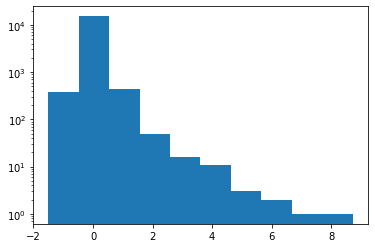

In [200]:
plt.yscale('log')
plt.hist(model.w)

### Experiments

In [18]:
accuracy_results = {}
roc_auc_results = {}

In [19]:
%%time
i = 0
for step_alpha in np.arange(0.1, 5.0, 0.5):
    for step_beta in np.arange(0.0, 2.0, 0.3):
        model = GDClassifier('binary_logistic', l2_coef=0.0, step_alpha=step_alpha, step_beta=step_beta, tolerance=1e-8, max_iter=700)
        t = time.time()
        model.fit(X_train, y_train.values)
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)
        acc = (y_test == preds).sum() / len(y_test)
        roc_auc = roc_auc_score(y_test, proba)
        print(f'step_alpha: {step_alpha} step_beta: {step_beta} acc: {acc} roc-auc: {roc_auc} time: {time.time() - t}')
        accuracy_results[step_alpha, step_beta] = acc
        roc_auc_results[step_alpha, step_beta] = roc_auc
        i += 1

step_alpha: 0.1 step_beta: 0.0 acc: 0.8069259044302574 roc-auc: 0.8910994656147498 time: 13.94235634803772
step_alpha: 0.1 step_beta: 0.3 acc: 0.7650899593731864 roc-auc: 0.8453832180353504 time: 13.844103574752808
step_alpha: 0.1 step_beta: 0.6 acc: 0.75 roc-auc: 0.7983013281394943 time: 13.993250131607056
step_alpha: 0.1 step_beta: 0.8999999999999999 acc: 0.7402785838653512 roc-auc: 0.7698997546412933 time: 13.85124921798706
step_alpha: 0.1 step_beta: 1.2 acc: 0.7306538982395048 roc-auc: 0.745812581621937 time: 13.884833812713623
step_alpha: 0.1 step_beta: 1.5 acc: 0.722189978719288 roc-auc: 0.7286666380556714 time: 13.778486728668213
step_alpha: 0.1 step_beta: 1.7999999999999998 acc: 0.7113077964790094 roc-auc: 0.7193218297377425 time: 13.673673152923584
step_alpha: 0.6 step_beta: 0.0 acc: 0.856403559682724 roc-auc: 0.9263350883149176 time: 13.902804613113403
step_alpha: 0.6 step_beta: 0.3 acc: 0.8134068485200232 roc-auc: 0.8956794722401151 time: 13.979488849639893
step_alpha: 0.6 s

In [22]:
i

70

In [23]:
import pickle

def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(accuracy_results, 'acc_results')
save_obj(roc_auc_results, 'roc_auc_results')

In [27]:
accuracy_results = {}
roc_auc_results = {}

In [28]:
%%time
i = 0
for step_alpha in np.arange(5.0, 10.0, 0.5):
    for step_beta in np.arange(0.0, 2.0, 0.3):
        model = GDClassifier('binary_logistic', l2_coef=0.0, step_alpha=step_alpha, step_beta=step_beta, tolerance=1e-8, max_iter=700)
        t = time.time()
        model.fit(X_train, y_train.values)
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)
        acc = (y_test == preds).sum() / len(y_test)
        roc_auc = roc_auc_score(y_test, proba)
        print(f'step_alpha: {step_alpha} step_beta: {step_beta} acc: {acc} roc-auc: {roc_auc} time: {time.time() - t}')
        accuracy_results[step_alpha, step_beta] = acc
        roc_auc_results[step_alpha, step_beta] = roc_auc
        i += 1

step_alpha: 5.0 step_beta: 0.0 acc: 0.8772489843296576 roc-auc: 0.9198792303029639 time: 14.04075813293457
step_alpha: 5.0 step_beta: 0.3 acc: 0.8668504546333914 roc-auc: 0.9335085851131443 time: 14.130613803863525
step_alpha: 5.0 step_beta: 0.6 acc: 0.835896691816599 roc-auc: 0.9117215507794283 time: 14.049916505813599
step_alpha: 5.0 step_beta: 0.8999999999999999 acc: 0.8058135035790288 roc-auc: 0.8836449251624369 time: 14.246953248977661
step_alpha: 5.0 step_beta: 1.2 acc: 0.7912555620042562 roc-auc: 0.8309556852639136 time: 14.106826782226562
step_alpha: 5.0 step_beta: 1.5 acc: 0.7270748694138132 roc-auc: 0.7652117908952644 time: 14.368064403533936
step_alpha: 5.0 step_beta: 1.7999999999999998 acc: 0.7519829754304508 roc-auc: 0.7491169851104852 time: 14.103551626205444
step_alpha: 5.5 step_beta: 0.0 acc: 0.8772973495840588 roc-auc: 0.9188268550792823 time: 14.09612774848938
step_alpha: 5.5 step_beta: 0.3 acc: 0.8688334300638422 roc-auc: 0.9345052088492232 time: 14.632304668426514
s

In [30]:
save_obj(accuracy_results, 'acc_results_5_to_10')
save_obj(roc_auc_results, 'roc_auc_results_5_to_10')

In [31]:
accuracy_results.values()

dict_values([0.8772489843296576, 0.8668504546333914, 0.835896691816599, 0.8058135035790288, 0.7912555620042562, 0.7270748694138132, 0.7519829754304508, 0.8772973495840588, 0.8688334300638422, 0.8383149545366608, 0.8088605146063068, 0.7929967111627008, 0.7253337202553686, 0.7395531050493326, 0.8266589282259624, 0.8711065970207004, 0.8409266782743278, 0.812536273940801, 0.793673824724318, 0.7245598761849488, 0.7377152253820856, 0.8773940800928612, 0.873089572451151, 0.8432965757399884, 0.8141323273360418, 0.7943509382859354, 0.7242696846585414, 0.7358773457148384, 0.8148094408976592, 0.8752176436448056, 0.845666473205649, 0.816212033275295, 0.7951731476107564, 0.7238343973689302, 0.7348616753724124, 0.8837782936738248, 0.8764267750048366, 0.8475527181272974, 0.818436834977752, 0.7956084349003676, 0.723399110079319, 0.7337976397755852, 0.8121009866511898, 0.8766686012768428, 0.8490036757593344, 0.8200328883729928, 0.7956084349003676, 0.7232540143161154, 0.7331688914683692, 0.8335267943509

In [32]:
acc_res = load_obj('acc_results_5_to_10')
roc_auc_res = load_obj('roc_auc_results_5_to_10')

In [33]:
# взял этот код отсюда https://stackoverflow.com/questions/33711107/create-heatmap-in-python-matplotlib-with-x-and-y-labels-from-dict-with-tuplefl

ser = pd.Series(list(roc_auc_results.values()),
                  index=pd.MultiIndex.from_tuples(roc_auc_results.keys()))
df = ser.unstack().fillna(0)

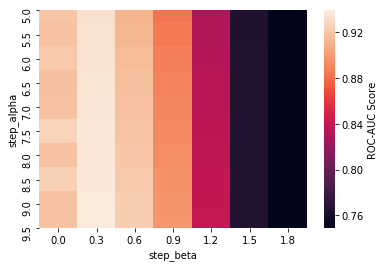

In [34]:
fig, ax = plt.subplots()

sns_plot = sns.heatmap(df, xticklabels=df.columns.values.round(2), ax=ax, cbar_kws={'label': 'ROC-AUC Score'})
ax.set_xlabel('step_beta')
ax.set_ylabel('step_alpha')
plt.savefig(fname='roc_auc_new.pdf', format='pdf')

In [35]:
ser = pd.Series(list(accuracy_results.values()),
                  index=pd.MultiIndex.from_tuples(accuracy_results.keys()))
df = ser.unstack().fillna(0)

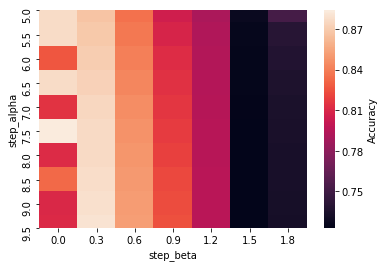

In [36]:
fig, ax = plt.subplots()

sns_plot = sns.heatmap(df, xticklabels=df.columns.values.round(2), ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_xlabel('step_beta')
ax.set_ylabel('step_alpha')
plt.savefig(fname='accuracy_new.pdf', format='pdf')

In [37]:
old_acc_res = load_obj('acc_results')
old_roc_auc_res = load_obj('roc_auc_results')

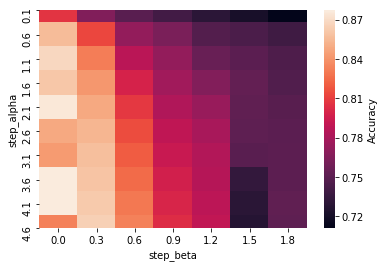

In [38]:
ser = pd.Series(list(old_acc_res.values()),
                  index=pd.MultiIndex.from_tuples(old_acc_res.keys()))
df = ser.unstack().fillna(0)
fig, ax = plt.subplots()

sns_plot = sns.heatmap(df, xticklabels=df.columns.values.round(2), ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_xlabel('step_beta')
ax.set_ylabel('step_alpha')
plt.savefig(fname='old_acc_res.pdf', format='pdf')

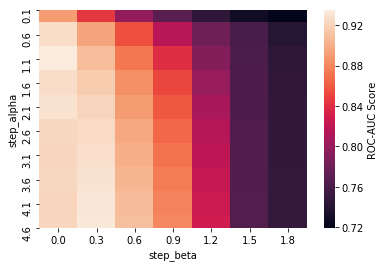

In [39]:
ser = pd.Series(list(old_roc_auc_res.values()),
                  index=pd.MultiIndex.from_tuples(old_roc_auc_res.keys()))
df = ser.unstack().fillna(0)
fig, ax = plt.subplots()

sns_plot = sns.heatmap(df, xticklabels=df.columns.values.round(2), ax=ax, cbar_kws={'label': 'ROC-AUC Score'})
ax.set_xlabel('step_beta')
ax.set_ylabel('step_alpha')
plt.savefig(fname='old_roc_auc_res.pdf', format='pdf')

Some plot functions

In [21]:
def plot_time_loss(hist, figsize=(10, 5), tick_freq = 10.0, title=None):
    plt.figure(figsize=figsize)
    exec_time = np.array(hist['time']).cumsum()
    plt.xticks(np.arange(0, exec_time[-1] + 1, tick_freq))
    plt.xlabel('Fitting time, sec')
    plt.ylabel('log-loss')
    plt.title(title)
    return plt.plot([0, *exec_time], np.array(hist['func']))

def plot_epoch_loss(hist, figsize=(10, 5), tick_freq = 1000.0, epoch_label=True, title=None):
    plt.figure(figsize=figsize)
    exec_time = np.array(hist['time']).cumsum()
    plt.xticks(np.arange(0, len(exec_time) + 1, tick_freq))
    if epoch_label:
        plt.xlabel('Epoch number')
    else:
        plt.xlabel('Iteration number')
    plt.ylabel('log-loss')
    plt.title(title)
    return plt.plot(np.arange(0, len(exec_time) + 1), np.array(hist['func']))

def plot_time_accuracy(hist, figsize=(10, 5), tick_freq = 10.0, title=None):
    plt.figure(figsize=figsize)
    exec_time = np.array(hist['time']).cumsum()
    plt.xticks(np.arange(0, exec_time[-1] + 1, tick_freq))
    plt.yticks(np.arange(0, 1.0, 0.02))
    plt.xlabel('Fitting time, sec')
    plt.ylabel('accuracy')
    plt.title(title)
    return plt.plot([0, *exec_time], np.array(hist['accuracy']))

def plot_epoch_accuracy(hist, figsize=(10, 5), tick_freq = 1000.0, epoch_label=True, title=None):
    plt.figure(figsize=figsize)
    exec_time = np.array(hist['time']).cumsum()
    plt.xticks(np.arange(0, len(exec_time) + 1, tick_freq))
    plt.yticks(np.arange(0, 1.0, 0.02))
    if epoch_label:
        plt.xlabel('Epoch number')
    else:
        plt.xlabel('Iteration number')
    plt.ylabel('accuracy')
    plt.title(title)
    return plt.plot(np.arange(0, len(exec_time) + 1), np.array(hist['accuracy']))

In [110]:
model1 = GDClassifier('binary_logistic', l2_coef=0.0, step_beta=0, step_alpha=5.0, tolerance=1e-8, max_iter=700)

In [111]:
%%time
hist1 = model1.fit(X_train, y_train.values, trace=True)

Wall time: 17.6 s


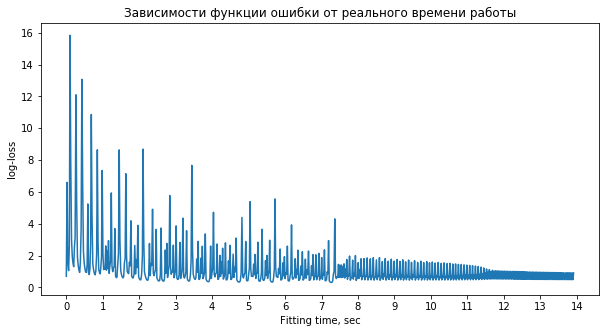

In [125]:
plot_time_loss(hist1, figsize=(10, 5), tick_freq=1.0, title='Зависимости функции ошибки от реального времени работы')
plt.savefig(fname='sb0sa5_time_loss.pdf', format='pdf')

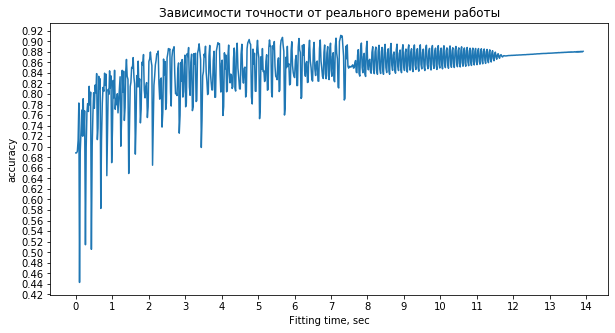

In [126]:
plot_time_accuracy(hist1, figsize=(10, 5), tick_freq=1.0, title='Зависимости точности от реального времени работы')
plt.savefig(fname='sb0sa5_time_acc.pdf', format='pdf')

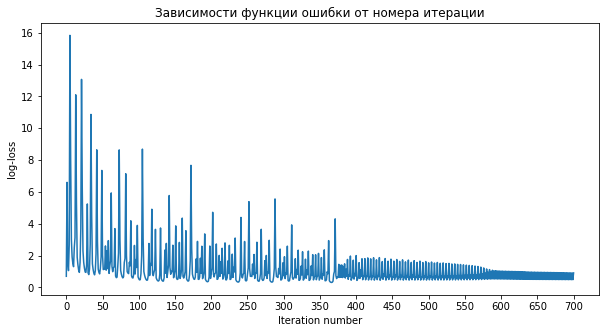

In [127]:
plot_epoch_loss(hist1, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости функции ошибки от номера итерации')
plt.savefig(fname='sb0sa5_epoch_loss.pdf', format='pdf')

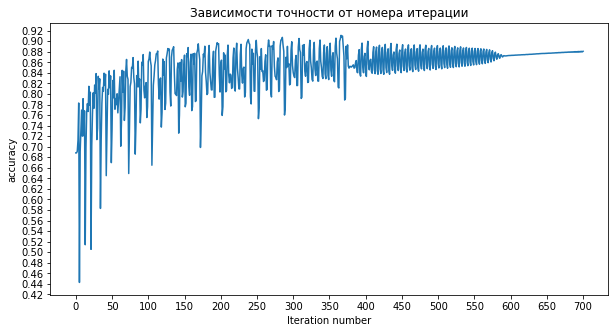

In [128]:
plot_epoch_accuracy(hist1, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости точности от номера итерации')
plt.savefig(fname='sb0sa5_epoch_acc.pdf', format='pdf')

In [119]:
model2 = GDClassifier('binary_logistic', l2_coef=0.0, step_beta=0.3, step_alpha=5.0, tolerance=1e-8, max_iter=700)

In [120]:
%%time
hist2 = model2.fit(X_train, y_train.values, trace=True)

Wall time: 17.6 s


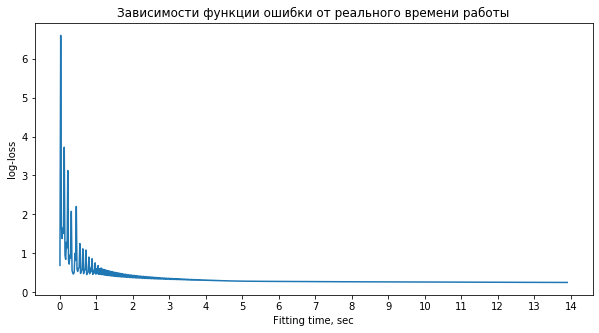

In [129]:
plot_time_loss(hist2, figsize=(10, 5), tick_freq=1.0, title='Зависимости функции ошибки от реального времени работы')
plt.savefig(fname='sb03sa5_time_loss.pdf', format='pdf')

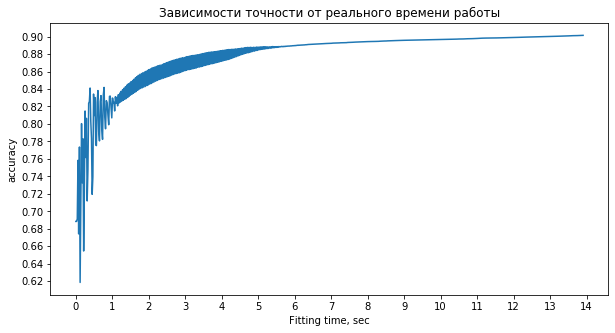

In [130]:
plot_time_accuracy(hist2, figsize=(10, 5), tick_freq=1.0, title='Зависимости точности от реального времени работы')
plt.savefig(fname='sb03sa5_time_acc.pdf', format='pdf')

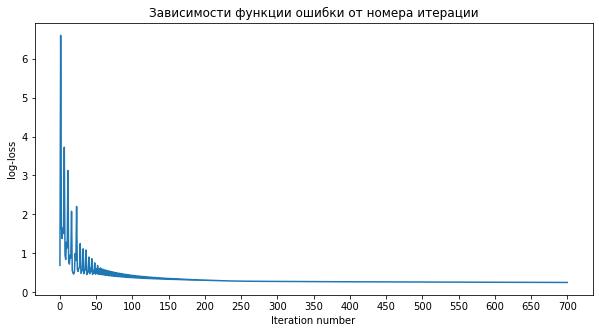

In [131]:
plot_epoch_loss(hist2, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости функции ошибки от номера итерации')
plt.savefig(fname='sb03sa5_epoch_loss.pdf', format='pdf')

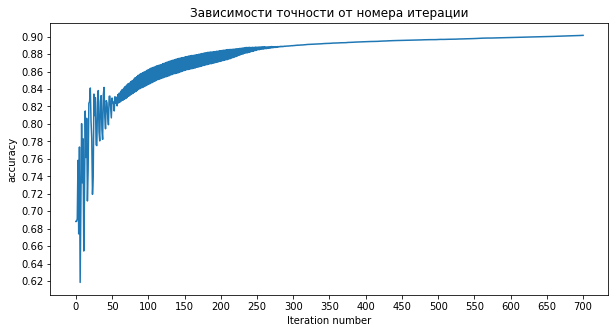

In [132]:
plot_epoch_accuracy(hist2, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости точности от номера итерации')
plt.savefig(fname='sb03sa5_epoch_acc.pdf', format='pdf')

In [139]:
model3 = GDClassifier('binary_logistic', l2_coef=0.0, step_beta=2.0, step_alpha=5.0, tolerance=1e-8, max_iter=700)

In [140]:
%%time
hist3 = model3.fit(X_train, y_train.values, trace=True)

Wall time: 17.6 s


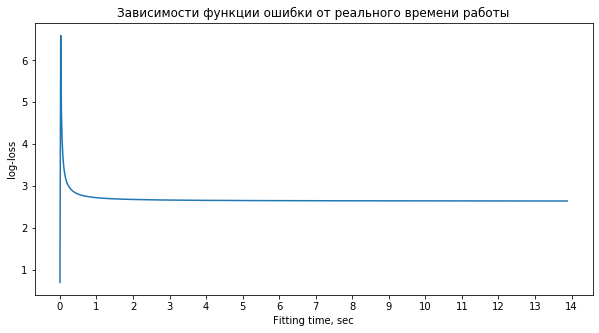

In [141]:
plot_time_loss(hist3, figsize=(10, 5), tick_freq=1.0, title='Зависимости функции ошибки от реального времени работы')
plt.savefig(fname='sb2sa5_time_loss.pdf', format='pdf')

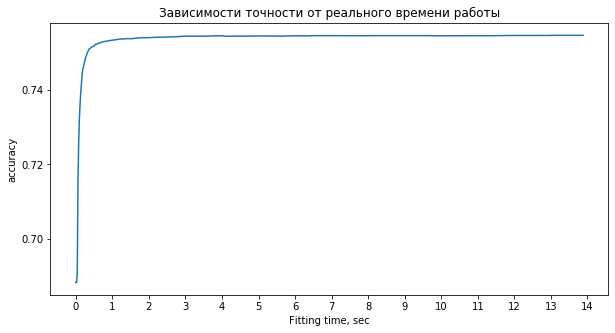

In [142]:
plot_time_accuracy(hist3, figsize=(10, 5), tick_freq=1.0, title='Зависимости точности от реального времени работы')
plt.savefig(fname='sb2sa5_time_acc.pdf', format='pdf')

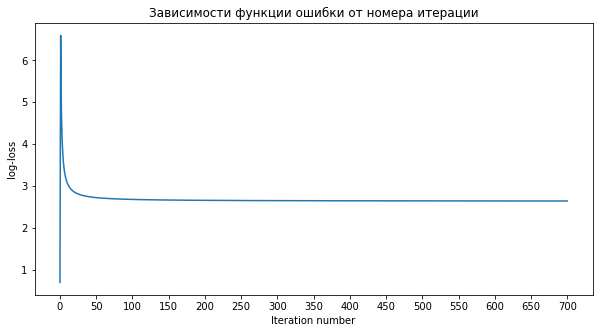

In [143]:
plot_epoch_loss(hist3, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости функции ошибки от номера итерации')
plt.savefig(fname='sb2sa5_epoch_loss.pdf', format='pdf')

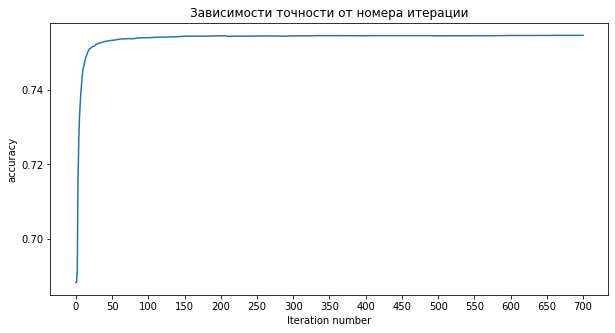

In [144]:
plot_epoch_accuracy(hist3, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости точности от номера итерации')
plt.savefig(fname='sb2sa5_epoch_acc.pdf', format='pdf')

Initial value

In [219]:
mdl = GDClassifier('binary_logistic', l2_coef=0.0, step_beta=0.3, step_alpha=5.0, tolerance=1e-8, max_iter=10)

In [220]:
mdl.fit(X_train, y_train.values)

In [221]:
w_0 = mdl.w

In [222]:
mdl = GDClassifier('binary_logistic', l2_coef=0.0, step_beta=0.3, step_alpha=5.0, tolerance=1e-8, max_iter=700)

In [223]:
hist4 = mdl.fit(X_train, y_train.values, trace=True, w_0=w_0)

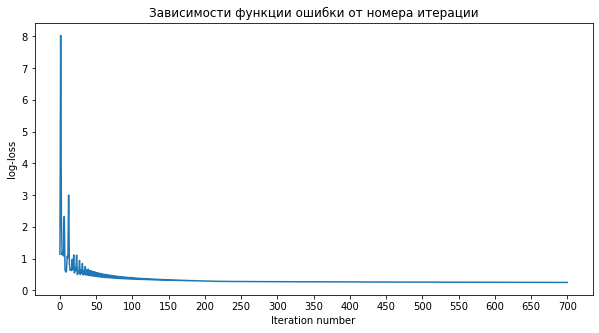

In [224]:
plot_epoch_loss(hist4, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости функции ошибки от номера итерации')
plt.savefig(fname='lucky_epoch_loss.pdf', format='pdf')

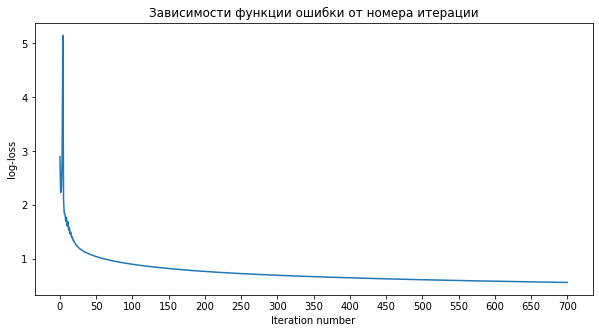

In [175]:
plot_epoch_loss(hist4, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости функции ошибки от номера итерации')
plt.savefig(fname='init3_epoch_loss.pdf', format='pdf')

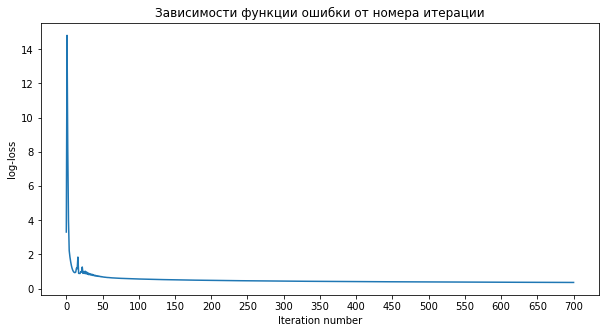

In [193]:
plot_epoch_loss(hist4, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости функции ошибки от номера итерации')
plt.savefig(fname='init3_epoch_loss.pdf', format='pdf')

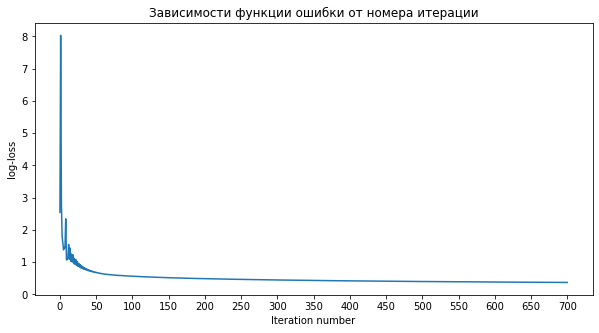

In [187]:
plot_epoch_loss(hist4, figsize=(10, 5), tick_freq=50.0, epoch_label=False, title='Зависимости функции ошибки от номера итерации')
plt.savefig(fname='init3_epoch_loss.pdf', format='pdf')

In [209]:
w_0_normal = np.random.randn(len(w_0))

In [205]:
w_0_normal = 2 * np.random.rand(len(w_0)) - 1

In [179]:
w_0_normal

array([ 0.51961978,  0.54007256,  0.5726543 , ...,  0.34811572,
       -0.90332862, -0.2602961 ])

### Stochastic gradient descent

In [52]:
sgd_model = SGDClassifier('binary_logistic', 100, step_alpha=5.0, step_beta=1.0, l2_coef=0.0, tolerance=1e-8)

In [61]:
%%time
hist_sgd1 = sgd_model.fit(X_train, y_train.values, trace=True)

Wall time: 25.1 s


In [62]:
preds = sgd_model.predict(X_test)

In [63]:
preds

array([-1, -1, -1, ...,  1, -1,  1])

In [56]:
# 100 batch step_beta 1.0
(y_test == preds).sum() / len(y_test)

0.8092474366415168

In [64]:
# 5000 batch
(y_test == preds).sum() / len(y_test)

0.803395240858967

In [51]:
# 100 batch
(y_test == preds).sum() / len(y_test)

0.8863900174114916

In [44]:
proba = sgd_model.predict_proba(X_test)

In [45]:
# 5000 batch
roc_auc_score(y_test, proba)

0.9445664629037747

In [38]:
# 100 batch
roc_auc_score(y_test, proba)

0.944535832047642

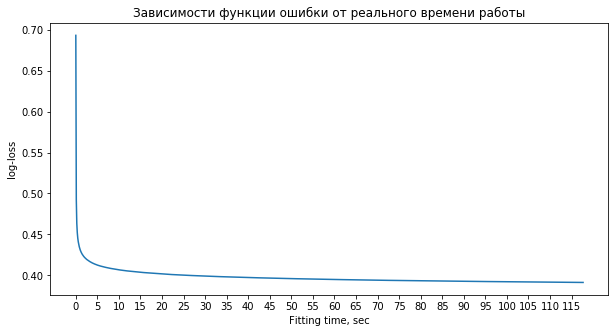

In [57]:
plot_time_loss(hist_sgd1, figsize=(10, 5), tick_freq=5.0, title='Зависимости функции ошибки от реального времени работы')
plt.savefig(fname='sgd100_1_time_loss.pdf', format='pdf')

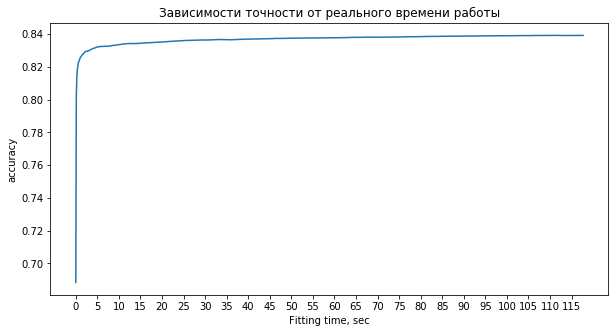

In [59]:
plot_time_accuracy(hist_sgd1, figsize=(10, 5), tick_freq=5.0, title='Зависимости точности от реального времени работы')
plt.savefig(fname='sgd100_1_time_acc.pdf', format='pdf')

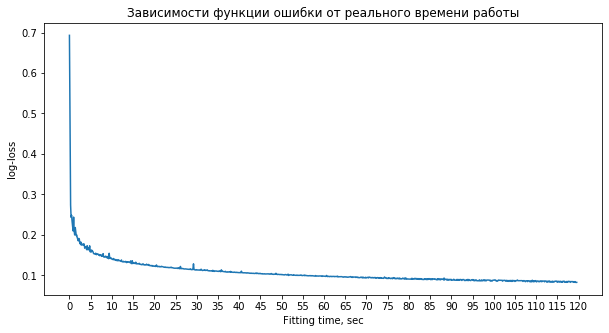

In [31]:
plot_time_loss(hist_sgd1, figsize=(10, 5), tick_freq=5.0, title='Зависимости функции ошибки от реального времени работы')
plt.savefig(fname='sgd100_time_loss.pdf', format='pdf')

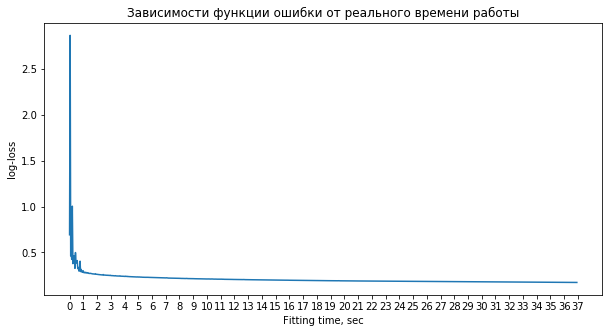

In [24]:
plot_time_loss(hist_sgd1, figsize=(10, 5), tick_freq=1.0, title='Зависимости функции ошибки от реального времени работы')
plt.savefig(fname='sgd100_time_loss.pdf', format='pdf')

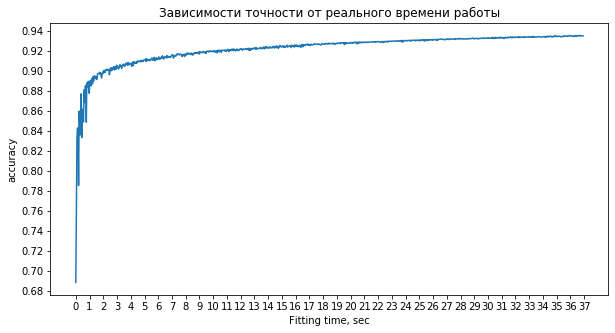

In [25]:
plot_time_accuracy(hist_sgd1, figsize=(10, 5), tick_freq=1.0, title='Зависимости точности от реального времени работы')
plt.savefig(fname='sgd100_time_acc.pdf', format='pdf')

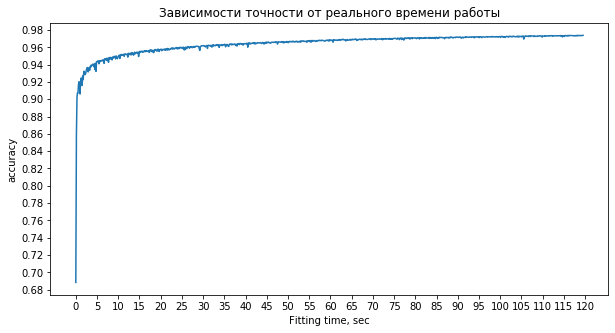

In [33]:
plot_time_accuracy(hist_sgd1, figsize=(10, 5), tick_freq=5.0, title='Зависимости точности от реального времени работы')
plt.savefig(fname='sgd100_time_acc.pdf', format='pdf')

In [47]:
np.array(hist_sgd1['accuracy']).max()

0.9354987418605097

In [50]:
np.array(hist_sgd1['accuracy']).max()

0.973723132479207

step_alpha, step_beta

In [65]:
accuracy_results = {}
roc_auc_results = {}

In [66]:
%%time
i = 0
for step_alpha in np.arange(0.1, 5.0, 0.5):
    for step_beta in np.arange(0.0, 2.0, 0.3):
        model = SGDClassifier('binary_logistic', 5000, l2_coef=0.0, step_alpha=step_alpha, step_beta=step_beta, tolerance=1e-8, max_iter=700)
        t = time.time()
        model.fit(X_train, y_train.values)
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)
        acc = (y_test == preds).sum() / len(y_test)
        roc_auc = roc_auc_score(y_test, proba)
        print(f'step_alpha: {step_alpha} step_beta: {step_beta} acc: {acc} roc-auc: {roc_auc} time: {time.time() - t}')
        accuracy_results[step_alpha, step_beta] = acc
        roc_auc_results[step_alpha, step_beta] = roc_auc
        i += 1

calc time:  0.0
step_alpha: 0.1 step_beta: 0.0 acc: 0.8664635325981814 roc-auc: 0.9336973699603349 time: 26.669240951538086
calc time:  0.0
step_alpha: 0.1 step_beta: 0.3 acc: 0.809102340878313 roc-auc: 0.8928184892375658 time: 26.622517824172974
calc time:  0.0
step_alpha: 0.1 step_beta: 0.6 acc: 0.7580769974850068 roc-auc: 0.8317648226347467 time: 29.851361989974976
calc time:  0.0
step_alpha: 0.1 step_beta: 0.8999999999999999 acc: 0.7441961694718514 roc-auc: 0.7802356376271613 time: 30.278104305267334
calc time:  0.0
step_alpha: 0.1 step_beta: 1.2 acc: 0.7308473592571096 roc-auc: 0.7489697572345948 time: 30.556416034698486
calc time:  0.0
step_alpha: 0.1 step_beta: 1.5 acc: 0.7179338363319792 roc-auc: 0.7280491821455981 time: 30.50367283821106
calc time:  0.0
step_alpha: 0.1 step_beta: 1.7999999999999998 acc: 0.7065680015476882 roc-auc: 0.7171876692292375 time: 30.196366548538208
calc time:  0.0
step_alpha: 0.6 step_beta: 0.0 acc: 0.886486747920294 roc-auc: 0.944415095423052 time: 3

calc time:  0.0
step_alpha: 4.6 step_beta: 0.6 acc: 0.8580963435867672 roc-auc: 0.9266821936252105 time: 30.90844750404358
calc time:  0.0
step_alpha: 4.6 step_beta: 0.8999999999999999 acc: 0.811955890887986 roc-auc: 0.8937008576606422 time: 30.78042960166931
calc time:  0.0
step_alpha: 4.6 step_beta: 1.2 acc: 0.7998645772876766 roc-auc: 0.8474175175136083 time: 30.520970106124878
calc time:  0.0
step_alpha: 4.6 step_beta: 1.5 acc: 0.7261559295801896 roc-auc: 0.7698558504141696 time: 30.560211181640625
calc time:  0.0
step_alpha: 4.6 step_beta: 1.7999999999999998 acc: 0.7386825304701102 roc-auc: 0.7507705852199305 time: 30.621256589889526
Wall time: 35min 38s


In [67]:
import pickle

def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(accuracy_results, 'acc_results_sgd')
save_obj(roc_auc_results, 'roc_auc_results_sgd')

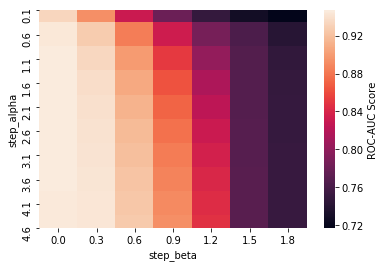

In [70]:
ser = pd.Series(list(roc_auc_results.values()),
                  index=pd.MultiIndex.from_tuples(roc_auc_results.keys()))
df = ser.unstack().fillna(0)

fig, ax = plt.subplots()

sns_plot = sns.heatmap(df, xticklabels=df.columns.values.round(2), ax=ax, cbar_kws={'label': 'ROC-AUC Score'})
ax.set_xlabel('step_beta')
ax.set_ylabel('step_alpha')
plt.savefig(fname='roc_auc_new_sgd.pdf', format='pdf')

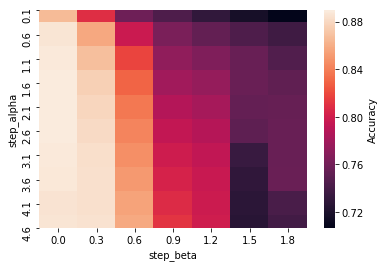

In [71]:
ser = pd.Series(list(accuracy_results.values()),
                  index=pd.MultiIndex.from_tuples(accuracy_results.keys()))
df = ser.unstack().fillna(0)

fig, ax = plt.subplots()

sns_plot = sns.heatmap(df, xticklabels=df.columns.values.round(2), ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_xlabel('step_beta')
ax.set_ylabel('step_alpha')
plt.savefig(fname='accuracy_new_sgd.pdf', format='pdf')

In [74]:
new_accuracy_results

{(0.1, 0.0): 0.8664635325981814,
 (0.1, 0.3): 0.809102340878313,
 (0.1, 0.6): 0.7580769974850068,
 (0.1, 0.8999999999999999): 0.7441961694718514,
 (0.1, 1.2): 0.7308473592571096,
 (0.1, 1.5): 0.7179338363319792,
 (0.1, 1.7999999999999998): 0.7065680015476882,
 (0.6, 0.0): 0.886486747920294,
 (0.6, 0.3): 0.8576610562971562,
 (0.6, 0.6): 0.7977848713484232,
 (0.6, 0.8999999999999999): 0.7636390017411492,
 (0.6, 1.2): 0.7530953762816792,
 (0.6, 1.5): 0.744099438963049,
 (0.6, 1.7999999999999998): 0.736602824530857,
 (1.1, 0.0): 0.8886148191139486,
 (1.1, 0.3): 0.8681563165022248,
 (1.1, 0.6): 0.818436834977752,
 (1.1, 0.8999999999999999): 0.7722963822789708,
 (1.1, 1.2): 0.7651866898819888,
 (1.1, 1.5): 0.7556103695105436,
 (1.1, 1.7999999999999998): 0.7456954923582898,
 (1.6, 0.0): 0.8893886631843684,
 (1.6, 0.3): 0.8759431224608242,
 (1.6, 0.6): 0.8297059392532404,
 (1.6, 0.8999999999999999): 0.7795511704391566,
 (1.6, 1.2): 0.7744728187270266,
 (1.6, 1.5): 0.755900561036951,
 (1.6, 1.7

In [73]:
%%time
i = 0
for step_alpha in np.arange(5.0, 10.0, 0.5):
    for step_beta in np.arange(0.0, 2.0, 0.3):
        model = SGDClassifier('binary_logistic', 5000, l2_coef=0.0, step_alpha=step_alpha, step_beta=step_beta, tolerance=1e-8, max_iter=700)
        t = time.time()
        model.fit(X_train, y_train.values)
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)
        acc = (y_test == preds).sum() / len(y_test)
        roc_auc = roc_auc_score(y_test, proba)
        print(f'step_alpha: {step_alpha} step_beta: {step_beta} acc: {acc} roc-auc: {roc_auc} time: {time.time() - t}')
        accuracy_results[step_alpha, step_beta] = acc
        roc_auc_results[step_alpha, step_beta] = roc_auc
        i += 1

calc time:  0.0
step_alpha: 5.0 step_beta: 0.0 acc: 0.8668504546333914 roc-auc: 0.9397699538358595 time: 29.621854066848755
calc time:  0.0
step_alpha: 5.0 step_beta: 0.3 acc: 0.8855194428322692 roc-auc: 0.9438004806358664 time: 29.85910439491272
calc time:  0.0
step_alpha: 5.0 step_beta: 0.6 acc: 0.8601276842716192 roc-auc: 0.927854672879714 time: 29.668694019317627
calc time:  0.0
step_alpha: 5.0 step_beta: 0.8999999999999999 acc: 0.814180692590443 roc-auc: 0.8957482640378468 time: 29.700250387191772
calc time:  0.0
step_alpha: 5.0 step_beta: 1.2 acc: 0.801363900174115 roc-auc: 0.8492141393052939 time: 29.694287061691284
calc time:  0.0
step_alpha: 5.0 step_beta: 1.5 acc: 0.7253820855097698 roc-auc: 0.7700198087305021 time: 29.76232123374939
calc time:  0.0
step_alpha: 5.0 step_beta: 1.7999999999999998 acc: 0.7366511897852582 roc-auc: 0.7508072978547448 time: 29.739091157913208
calc time:  0.0
step_alpha: 5.5 step_beta: 0.0 acc: 0.8556297156123042 roc-auc: 0.9367637350728818 time: 29

calc time:  0.0
step_alpha: 9.5 step_beta: 0.6 acc: 0.8708164054942928 roc-auc: 0.9352426633578238 time: 25.795454025268555
calc time:  0.0
step_alpha: 9.5 step_beta: 0.8999999999999999 acc: 0.83633197910621 roc-auc: 0.9104397160390897 time: 26.485081911087036
calc time:  0.0
step_alpha: 9.5 step_beta: 1.2 acc: 0.8110853163087638 roc-auc: 0.8591741062190859 time: 25.987629413604736
calc time:  0.0
step_alpha: 9.5 step_beta: 1.5 acc: 0.7214644999032694 roc-auc: 0.7709036254603632 time: 26.501389980316162
calc time:  0.0
step_alpha: 9.5 step_beta: 1.7999999999999998 acc: 0.732540143161153 roc-auc: 0.7510598803383408 time: 26.820446252822876
Wall time: 31min 46s


In [83]:
sgd_model = SGDClassifier('binary_logistic', 5000, step_alpha=5.0, step_beta=0.0, l2_coef=0.0, tolerance=1e-8)

In [84]:
%%time
hist_sgd2 = sgd_model.fit(X_train, y_train.values, trace=True)

calc time:  0.0
Wall time: 39.9 s


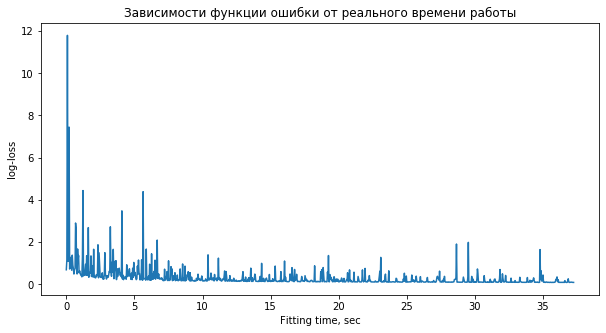

In [85]:
plot_time_loss(hist_sgd2, figsize=(10, 5), tick_freq=5.0, title='Зависимости функции ошибки от реального времени работы')
plt.savefig(fname='sgd5000_b0_time_loss.pdf', format='pdf')

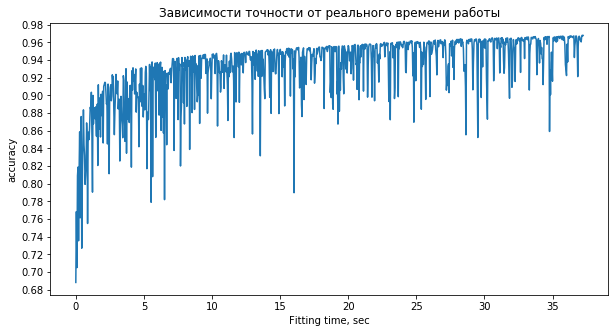

In [86]:
plot_time_accuracy(hist_sgd2, figsize=(10, 5), tick_freq=5.0, title='Зависимости точности от реального времени работы')
plt.savefig(fname='sgd5000_b0_time_acc.pdf', format='pdf')

In [77]:
new_acc_res = {}
new_roc_res = {}
for x in accuracy_results.keys():
    if x[0] >= 5.0:
        new_acc_res[x] = accuracy_results[x]
        
for x in roc_auc_results.keys():
    if x[0] >= 5.0:
        new_roc_res[x] = roc_auc_results[x]


In [79]:
new_roc_res

{(5.0, 0.0): 0.9397699538358595,
 (5.0, 0.3): 0.9438004806358664,
 (5.0, 0.6): 0.927854672879714,
 (5.0, 0.8999999999999999): 0.8957482640378468,
 (5.0, 1.2): 0.8492141393052939,
 (5.0, 1.5): 0.7700198087305021,
 (5.0, 1.7999999999999998): 0.7508072978547448,
 (5.5, 0.0): 0.9367637350728818,
 (5.5, 0.3): 0.9441387740259529,
 (5.5, 0.6): 0.9291548417411871,
 (5.5, 0.8999999999999999): 0.8980595508013803,
 (5.5, 1.2): 0.8510810566921766,
 (5.5, 1.5): 0.7701873239995121,
 (5.5, 1.7999999999999998): 0.7508626276131686,
 (6.0, 0.0): 0.9454197542097977,
 (6.0, 0.3): 0.9444084143450114,
 (6.0, 0.6): 0.9302928279881325,
 (6.0, 0.8999999999999999): 0.9001698836112921,
 (6.0, 1.2): 0.8526445454840968,
 (6.0, 1.5): 0.7703244303751152,
 (6.0, 1.7999999999999998): 0.7509112263519386,
 (6.5, 0.0): 0.9455715156743584,
 (6.5, 0.3): 0.9446272307489758,
 (6.5, 0.6): 0.9312531497204396,
 (6.5, 0.8999999999999999): 0.902067270931332,
 (6.5, 1.2): 0.8540125683507855,
 (6.5, 1.5): 0.7704417598718671,
 (6.5,

In [80]:
save_obj(new_acc_res, 'new_acc_results_sgd')
save_obj(new_roc_res, 'new_roc_auc_results_sgd')

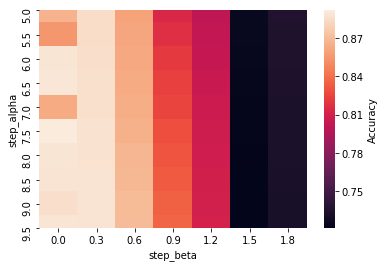

In [81]:
ser = pd.Series(list(new_acc_res.values()),
                  index=pd.MultiIndex.from_tuples(new_acc_res.keys()))
df = ser.unstack().fillna(0)

fig, ax = plt.subplots()

sns_plot = sns.heatmap(df, xticklabels=df.columns.values.round(2), ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_xlabel('step_beta')
ax.set_ylabel('step_alpha')
plt.savefig(fname='new_accuracy_new_sgd.pdf', format='pdf')

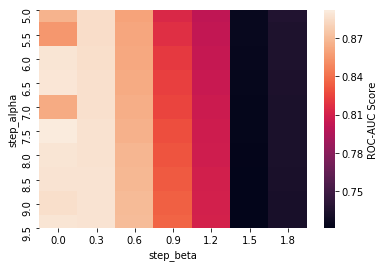

In [82]:
ser = pd.Series(list(new_acc_res.values()),
                  index=pd.MultiIndex.from_tuples(new_acc_res.keys()))
df = ser.unstack().fillna(0)

fig, ax = plt.subplots()

sns_plot = sns.heatmap(df, xticklabels=df.columns.values.round(2), ax=ax, cbar_kws={'label': 'ROC-AUC Score'})
ax.set_xlabel('step_beta')
ax.set_ylabel('step_alpha')
plt.savefig(fname='new_roc_auc_new_sgd.pdf', format='pdf')

In [21]:
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet

In [22]:
lem = WordNetLemmatizer() 

References:
https://www.datacamp.com/community/tutorials/stemming-lemmatization-python<br>
https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

In [23]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bulti\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [26]:
texts_nltk = []

for item in train['comment_text'].values:
    texts_nltk.append(" ".join([lem.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(item)]))

In [29]:
tests_nltk = []

for item in test['comment_text'].values:
    tests_nltk.append(" ".join([lem.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(item)]))

In [30]:
texts_nltk

['explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now 89 205 38 27',
 'd aww he match this background colour i m seemingly stuck with thanks talk 21 51 january 11 2016 utc',
 'hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info',
 'more i can t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a ba

In [203]:
X_train

<52061x16051 sparse matrix of type '<class 'numpy.float64'>'
	with 2048219 stored elements in COOrdinate format>

In [31]:
count_vec = CountVectorizer(**count_vectorizer_params)
X_train_lem = count_vec.fit_transform(texts_nltk)
X_test_lem = count_vec.transform(tests_nltk)

In [32]:
X_train_lem

<52061x12979 sparse matrix of type '<class 'numpy.int64'>'
	with 1904543 stored elements in Compressed Sparse Row format>

In [35]:
# appending identity vectors 
id_vec_train = scipy.sparse.csr_matrix(np.ones(X_train_lem.shape[0])[:, np.newaxis])
id_vec_test = scipy.sparse.csr_matrix(np.ones(X_test_lem.shape[0])[:, np.newaxis])

X_train_lem = scipy.sparse.hstack((X_train_lem, id_vec_train))
X_test_lem = scipy.sparse.hstack((X_test_lem, id_vec_test))

In [166]:
model = GDClassifier('binary_logistic', l2_coef=0, step_alpha=5.0, step_beta=0.1, tolerance=1e-8, max_iter=5000)

In [204]:
%%time
model.fit(X_train, y_train.values)

Wall time: 1min 46s


In [205]:
preds = model.predict(X_test)
proba = model.predict_proba(X_test)
print(preds[:10], '\n', proba[:10])

[-1  1 -1 -1 -1 -1 -1 -1  1 -1] 
 [4.67730953e-02 7.58954511e-01 3.87595071e-01 1.19380945e-03
 3.69022978e-04 1.40824680e-01 3.70120299e-02 1.55922632e-01
 7.08189891e-01 2.48030467e-01]


In [206]:
# bag of words без лемматизации
(y_test == preds).sum() / len(y_test)

0.8878409750435288

In [132]:
X_train_lem.shape

(52061, 12980)

In [90]:
(y_test == preds).sum() / len(y_test)

0.8959179725285356

In [85]:
(y_test == preds).sum() / len(y_test)

0.8920003869220352

In [170]:
roc_auc_score(y_test, proba)

0.9477113029379575

tf-idf or countvectorizer

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [188]:
tfidfvec = TfidfVectorizer(min_df = 0.0001)

In [189]:
X_train_tfidf = tfidfvec.fit_transform(texts_nltk)
X_test_tfidf = tfidfvec.transform(tests_nltk)

In [197]:
X_train_tfidf = tfidfvec.fit_transform(train['comment_text'])
X_test_tfidf = tfidfvec.transform(test['comment_text'])

In [198]:
# appending identity vectors 
id_vec_train = scipy.sparse.csr_matrix(np.ones(X_train_tfidf.shape[0])[:, np.newaxis])
id_vec_test = scipy.sparse.csr_matrix(np.ones(X_test_tfidf.shape[0])[:, np.newaxis])

X_train_tfidf = scipy.sparse.hstack((X_train_tfidf, id_vec_train))
X_test_tfidf = scipy.sparse.hstack((X_test_tfidf, id_vec_test))

In [199]:
model = GDClassifier('binary_logistic', l2_coef=0, step_alpha=5.0, step_beta=0.1, tolerance=1e-8, max_iter=5000)

In [200]:
%%time
model.fit(X_train_tfidf, y_train.values)

Wall time: 1min 48s


In [201]:
preds = model.predict(X_test_tfidf)
proba = model.predict_proba(X_test_tfidf)
print(preds[:10], '\n', proba[:10])

[-1  1 -1 -1 -1 -1 -1 -1 -1 -1] 
 [0.04377567 0.70471216 0.41246137 0.06292181 0.0095627  0.05864138
 0.07867729 0.08358761 0.37984478 0.1623039 ]


In [202]:
# без лемматизации
(y_test == preds).sum() / len(y_test)

0.8766202360224414

In [194]:
# с лемматизацией
(y_test == preds).sum() / len(y_test)

0.8804894563745406

In [195]:
roc_auc_score(y_test, proba)

0.9482468490532164

In [196]:
X_train_tfidf.shape

(52061, 12980)

In [207]:
X_train_lem

<52061x12980 sparse matrix of type '<class 'numpy.float64'>'
	with 1956604 stored elements in COOrdinate format>

min_df, max_df

In [208]:
texts_nltk

['explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now 89 205 38 27',
 'd aww he match this background colour i m seemingly stuck with thanks talk 21 51 january 11 2016 utc',
 'hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info',
 'more i can t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a ba

In [285]:
count_vectorizer_params = {
    'min_df': 0.0001
}

In [286]:
count_vec = CountVectorizer(**count_vectorizer_params)
X_train = count_vec.fit_transform(texts_nltk)
X_test = count_vec.transform(tests_nltk)

In [287]:
X_train.shape

(52061, 12979)

In [288]:
# appending identity vectors 
id_vec_train = scipy.sparse.csr_matrix(np.ones(X_train.shape[0])[:, np.newaxis])
id_vec_test = scipy.sparse.csr_matrix(np.ones(X_test.shape[0])[:, np.newaxis])

X_train = scipy.sparse.hstack((X_train, id_vec_train))
X_test = scipy.sparse.hstack((X_test, id_vec_test))

In [289]:
model = GDClassifier('binary_logistic', l2_coef=0, step_alpha=5.0, step_beta=0.1, tolerance=1e-8, max_iter=5000)

In [290]:
%%time
model.fit(X_train, y_train.values)

Wall time: 1min 39s


In [291]:
preds = model.predict(X_test)
proba = model.predict_proba(X_test)
print(preds[:10], '\n', proba[:10])

[-1  1 -1 -1 -1 -1 -1 -1 -1 -1] 
 [1.23104445e-02 7.02826097e-01 1.06396444e-02 1.63438878e-06
 7.04826010e-05 1.13169773e-01 1.03093770e-02 1.33464859e-01
 4.76550397e-01 2.13008827e-01]


In [292]:

(y_test == preds).sum() / len(y_test)

0.8959179725285356

In [293]:
roc_auc_score(y_test, proba)

0.9477113029379575

In [321]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [322]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
class_names = [1, -1]

Confusion matrix, without normalization
[[13331  1102]
 [ 1050  5193]]


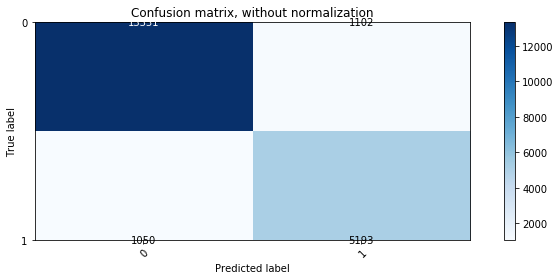

In [323]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.values, preds, classes=class_names, title='Confusion matrix, without normalization')

In [337]:
5193 / (5193+1102)

0.8249404289118348

In [335]:
cm

array([[13331,  1102],
       [ 1050,  5193]], dtype=int64)

In [326]:
cm = confusion_matrix(y_test.values, preds)

In [344]:
y_test.values

array([-1, -1, -1, ...,  1,  1,  1])

In [351]:
proba

array([1.23e-02, 7.03e-01, 1.06e-02, ..., 7.18e-01, 9.77e-04, 1.00e+00])

In [349]:
y_test.values

array([-1, -1, -1, ...,  1,  1,  1])

In [348]:
test.iloc[-2].comment_text

'iran that s right iran it was our drone and it was spreading homosexual western ideas over iran we call it the bone drone get used to it you fabulous bearded mullahs let me just say that the wording used for the recent iran incident was misleading at best most people do not know that international airspace starts 12 nautical miles off the coast so saying that the incident supposedly we should definitely keep the supposedly unless you believe what professional liars and spin doctors feed you like it s the word of dog which wouldn t surprise me considering the massive influx of right wing scum shills and provocateurs who ve invaded wikipedia in the past 5 years and turned it into a cesspool happened 16 miles from iran does not make sense it makes more sense to tell the god damned mother fucking truth and say that it supposedly occurred four 4 miles from iranian air space while we the usa were supposedly using an expensive to operate piece of military equipment to do surveillance and rec

In [342]:
texts_nltk[1]

'd aww he match this background colour i m seemingly stuck with thanks talk 21 51 january 11 2016 utc'

In [358]:
proba[8]

0.47655039694137274

In [356]:
test.iloc[8].comment_text

'arabs are committing genocide in iraq but no protests in europe may europe also burn in hell'

In [364]:
y_test.values[17]

-1

In [365]:
preds[17]

1

In [367]:
test.iloc[17].comment_text

'balance this page has one sentence about the basic definition of the word and a huge amount about the slang profane uses perhaps the former should be extended is there no information about female dogs available beyond their name this is an encyclopaedia not a dictionary i feel that whoever is looking this definition up is very appropiate and should be deleted from wikipedia immediatly this word is used very often and is also a very mean word i belive that is majorly true very much so okay so the good meaning is a female dog bitch it also stands for the name brittany fellows preceding unsigned comment added by etymology the word bitch is from the old norse bikkjuna meaning female of the dog of unknown origin grimm derives the old norse words from lapp pittja but oed notes that the converse is equally possible the adj bitchy was first seen in 1925 the verb meaning to complain in 1930 slang bitchen good is attested to the 1950 s reclaiming the word bitch the word bitch is actually only o

In [363]:
(y_test.values != preds)[10:20]

array([False, False, False, False, False, False, False,  True, False,
       False])

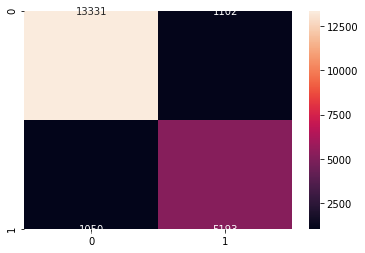

In [334]:
sns.heatmap(cm, annot=True, fmt="d")

In [333]:
pip install matplotlib==3.1.0

  Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'c:\\conda\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

